In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from sklearn import preprocessing
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

cuda


In [2]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [3]:
# create RFF features
def create_rff_features(X, num_features, gamma, random_state):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=gamma, random_state=random_state) # gamma  = 1/(2 * sigma**2)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [4]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [5]:
def plot_reconstructed_and_original_image(original_img, net, X, title="", scale=1):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples* scale**2, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height*scale, width*scale, num_channels)

    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [6]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [7]:
# Read in a image from torchvision
img = torchvision.io.read_image('dog.jpg')
print(img.shape)

torch.Size([3, 1365, 2048])


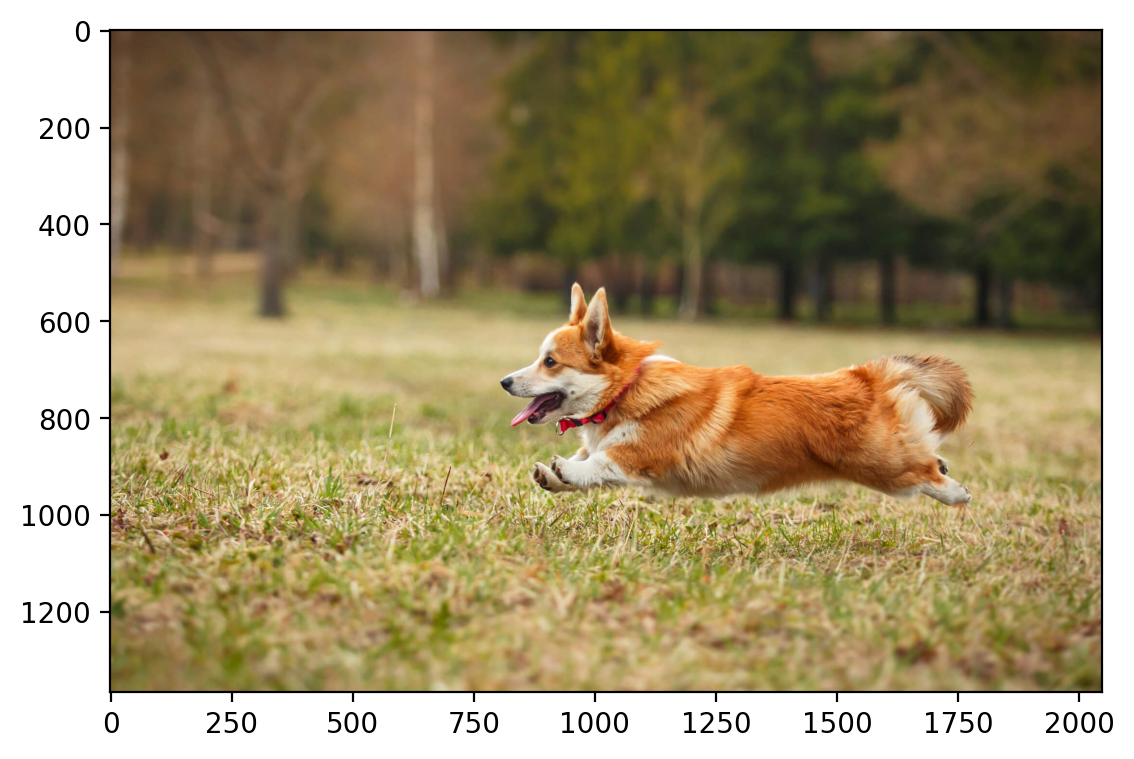

In [8]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [9]:
scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)
img_scaled.shape, img_scaled

(torch.Size([3, 1365, 2048]),
 tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
          [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
          [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
          ...,
          [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
          [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
          [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],
 
         [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
          [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
          [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
          ...,
          [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
          [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
          [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],
 
         [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
          [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
          

torch.Size([3, 400, 400])


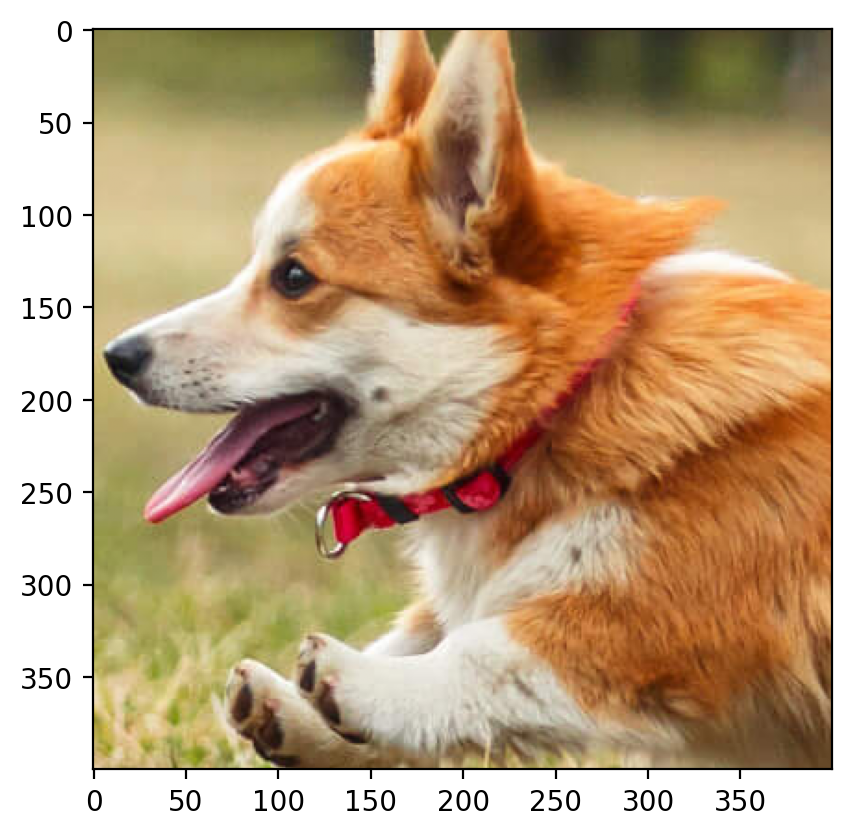

In [10]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 550, 800, 400, 400)
crop = crop.to(device)
print(crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

torch.Size([3, 200, 200])


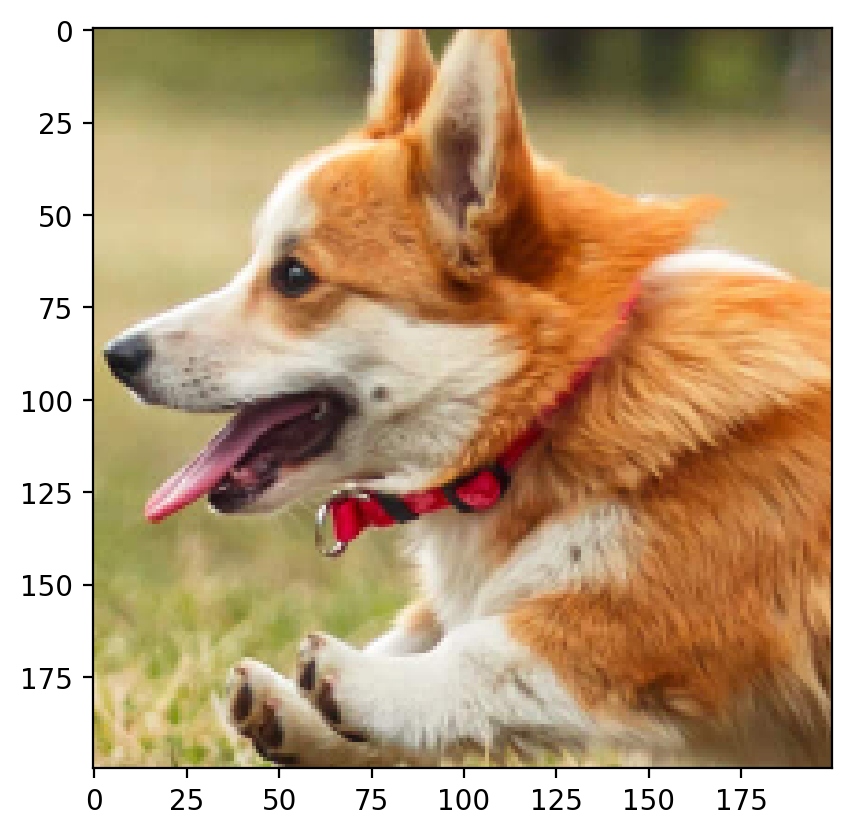

In [11]:
trans = torchvision.transforms.transforms.Resize((200,200))
resized_image = trans(crop)
resized_image = resized_image.to(device)
print(resized_image.shape)
plt.imshow(rearrange(resized_image, 'c h w -> h w c').cpu().numpy())

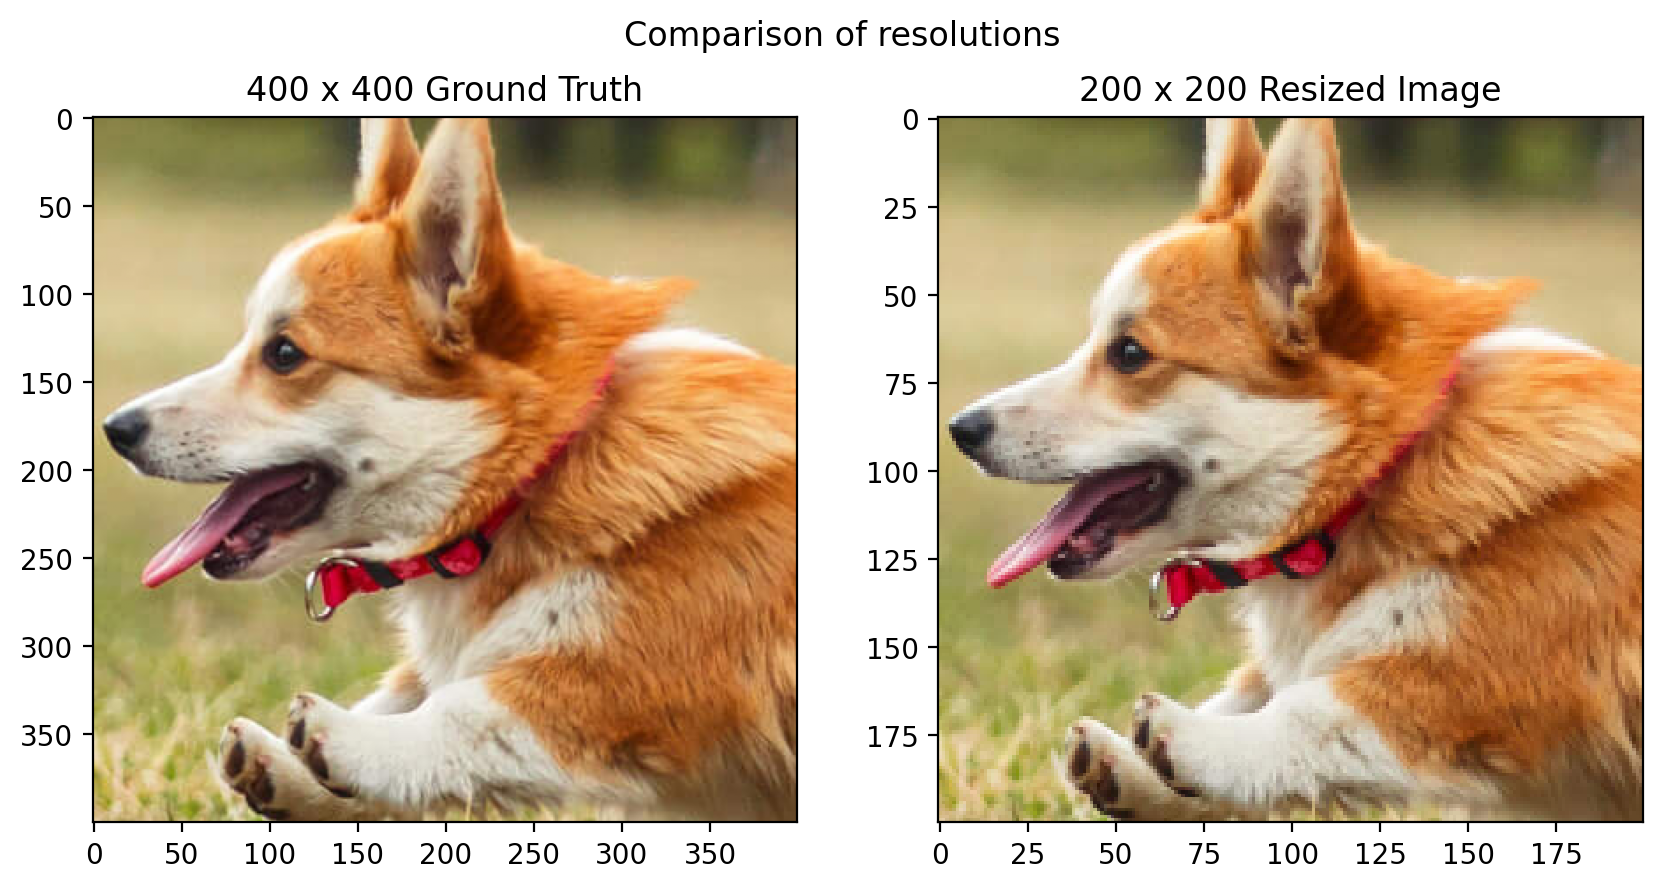

In [12]:
fig, ax = plt.subplots(1,2, figsize = (10,6))
fig.suptitle('Comparison of resolutions')
ax[0].imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())
ax[0].set_title('400 x 400 Ground Truth')
ax[1].set_title('200 x 200 Resized Image')
ax[1].imshow(rearrange(resized_image, 'c h w -> h w c').cpu().numpy())
fig.subplots_adjust(top=1.1)
plt.show()

In [13]:
scale = 1
dog_X, dog_Y = create_coordinate_map(resized_image, scale=scale)
dog_X.shape, dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [14]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu()) # MinMaxScaler on dog_X from -1 to 1
dog_X_scaled = scaler_X.transform(dog_X.cpu()) # Scale the coordinates
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)
dog_X_scaled = dog_X_scaled.float()
dog_X_scaled.shape, dog_X_scaled[:10, :] # First 10 entries of dog_X scaled by MinMaxScaler from -1 to 1

(torch.Size([40000, 2]),
 tensor([[-1.0000, -1.0000],
         [-1.0000, -0.9899],
         [-1.0000, -0.9799],
         [-1.0000, -0.9698],
         [-1.0000, -0.9598],
         [-1.0000, -0.9497],
         [-1.0000, -0.9397],
         [-1.0000, -0.9296],
         [-1.0000, -0.9196],
         [-1.0000, -0.9095]], device='cuda:0'))

In [15]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features): # Neural Network has "in_features" number of input features and "out_features" number of output features.
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [39]:
X_rff = create_rff_features(dog_X_scaled, 25000, 100, random_state = 42) # num_of_features = 37500, gamma = 0.008

In [40]:
X_rff, X_rff.shape

(tensor([[ 0.0089, -0.0067,  0.0075,  ...,  0.0089,  0.0076,  0.0049],
         [ 0.0089, -0.0067,  0.0075,  ...,  0.0089,  0.0076,  0.0049],
         [ 0.0089, -0.0067,  0.0075,  ...,  0.0089,  0.0076,  0.0049],
         ...,
         [ 0.0089, -0.0065,  0.0078,  ...,  0.0085,  0.0085,  0.0073],
         [ 0.0089, -0.0065,  0.0078,  ...,  0.0085,  0.0085,  0.0073],
         [ 0.0089, -0.0065,  0.0078,  ...,  0.0085,  0.0085,  0.0074]],
        device='cuda:0'),
 torch.Size([40000, 25000]))

In [41]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=25000, out_features=3, bias=True)
)

In [42]:
train(net, 0.001, X_rff, dog_Y, 2500)

Epoch 0 loss: 0.346480
Epoch 100 loss: 0.036905
Epoch 200 loss: 0.036888
Epoch 300 loss: 0.036879
Epoch 400 loss: 0.036868
Epoch 500 loss: 0.036856
Epoch 600 loss: 0.036842
Epoch 700 loss: 0.036827
Epoch 800 loss: 0.036810
Epoch 900 loss: 0.036792
Epoch 1000 loss: 0.036773
Epoch 1100 loss: 0.036753
Epoch 1200 loss: 0.036732
Epoch 1300 loss: 0.036709
Epoch 1400 loss: 0.036686
Epoch 1500 loss: 0.036661
Epoch 1600 loss: 0.036636
Epoch 1700 loss: 0.036609
Epoch 1800 loss: 0.036582
Epoch 1900 loss: 0.036554
Epoch 2000 loss: 0.036526
Epoch 2100 loss: 0.036496
Epoch 2200 loss: 0.036466
Epoch 2300 loss: 0.036435
Epoch 2400 loss: 0.036404


0.036372553557157516

In [43]:
torch.cuda.empty_cache()

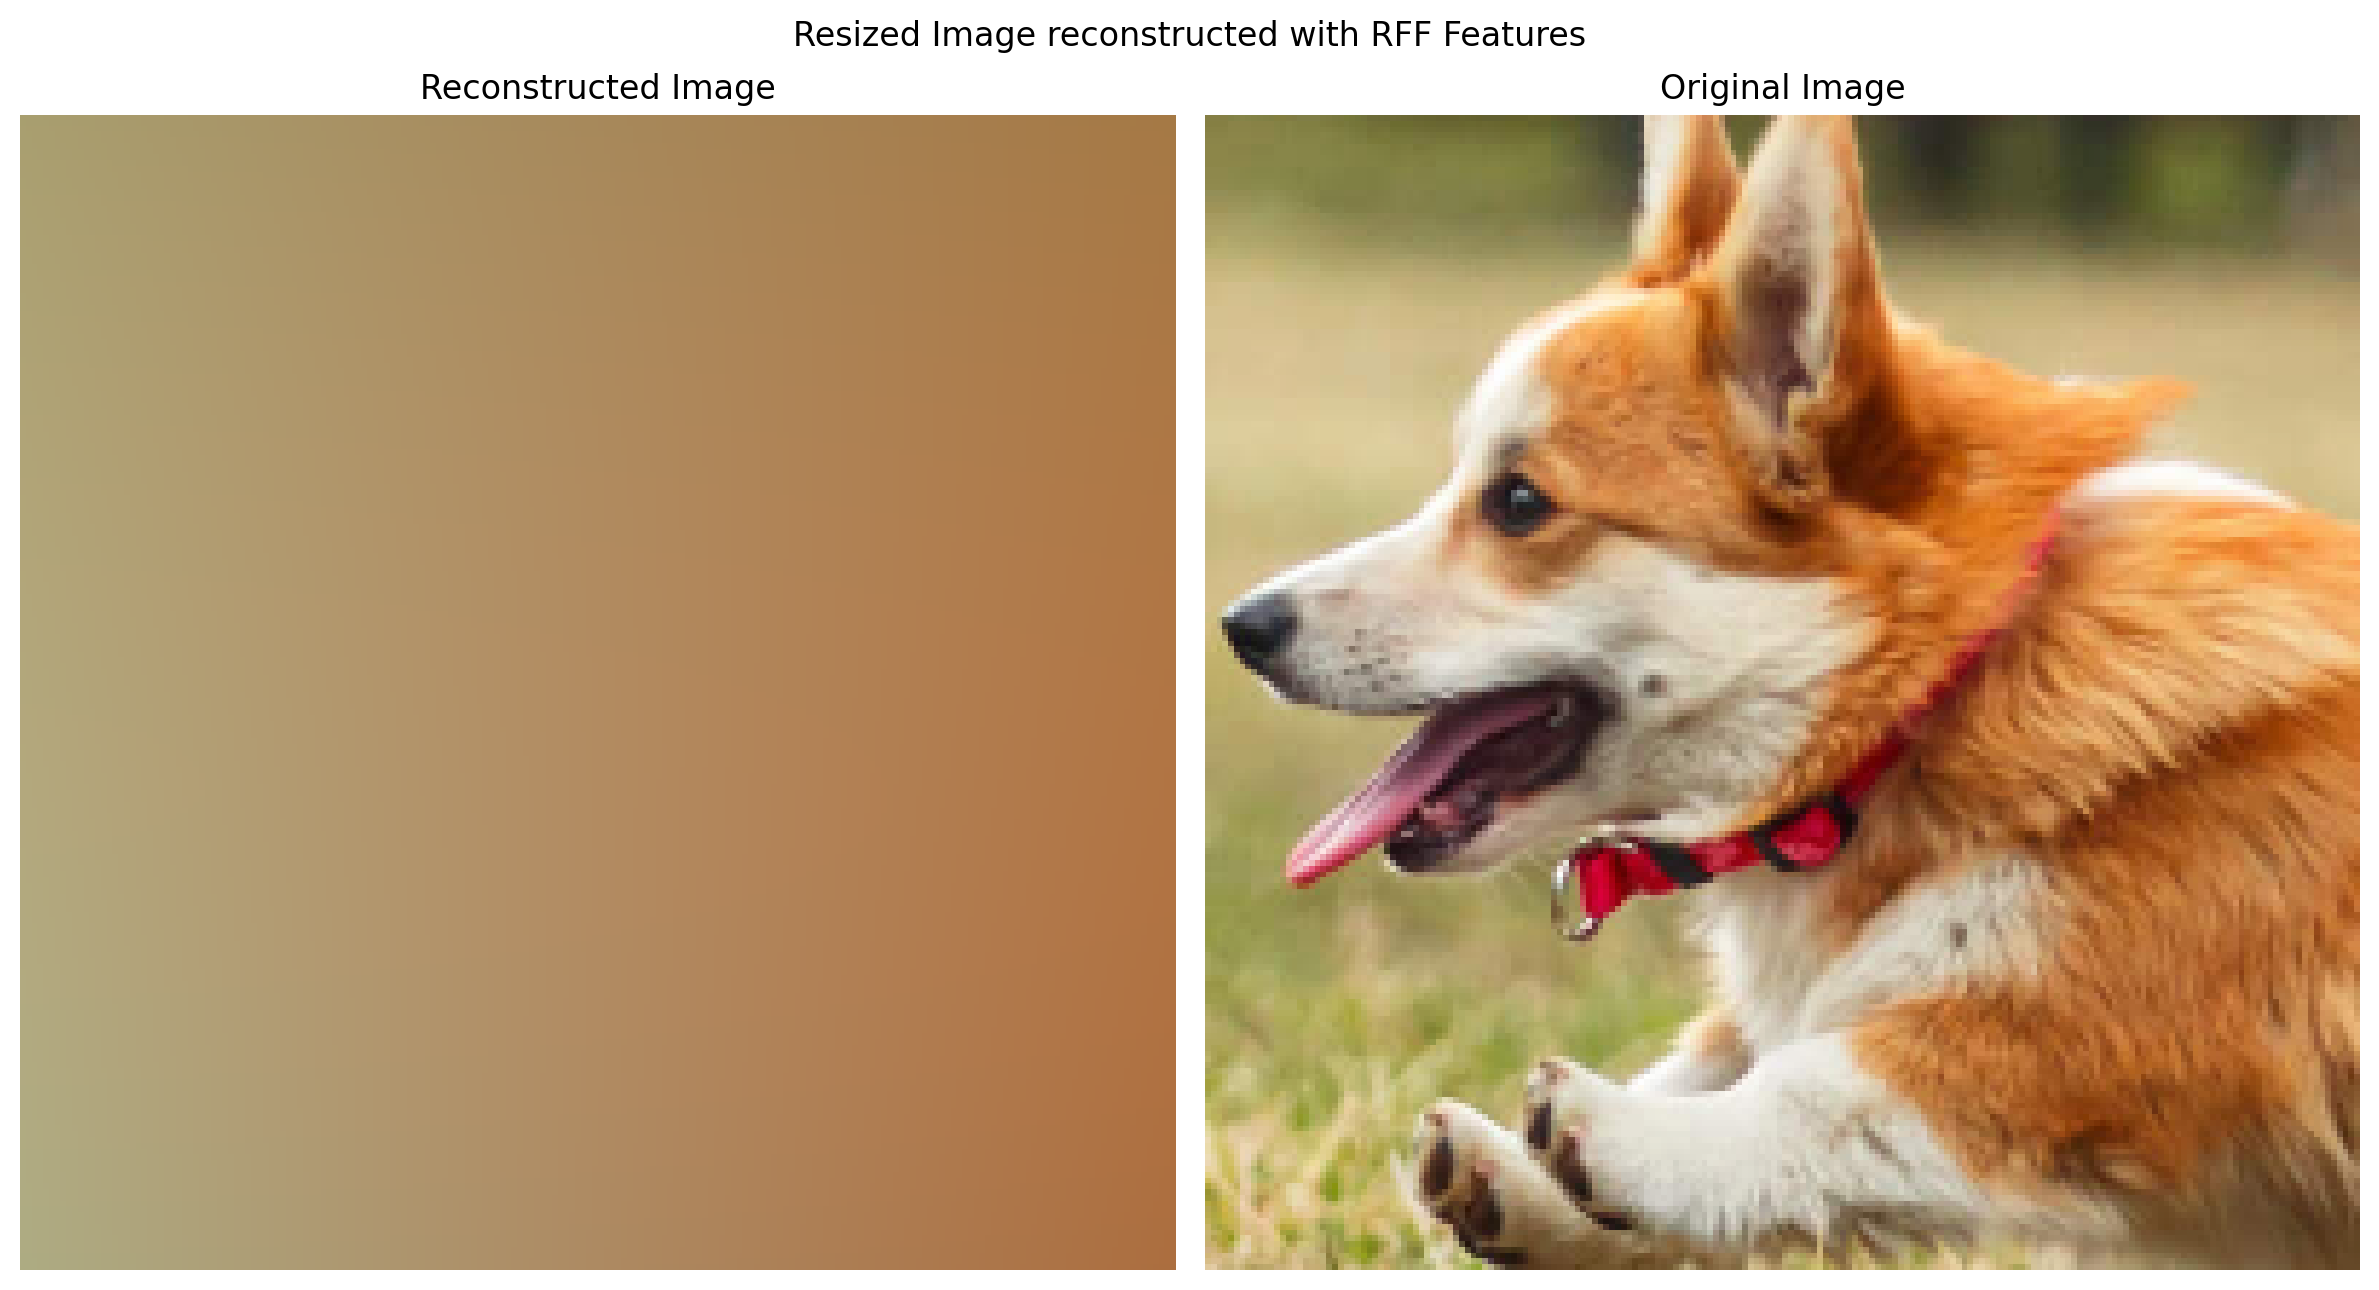

In [44]:
plot_reconstructed_and_original_image(resized_image, net, X_rff,'Resized Image reconstructed with RFF Features', scale=1)

Epoch 0 loss: 0.347246
Epoch 100 loss: 0.220941
Epoch 200 loss: 0.140731
Epoch 300 loss: 0.088332
Epoch 400 loss: 0.054631
Epoch 500 loss: 0.033358
Epoch 600 loss: 0.020179
Epoch 700 loss: 0.012167
Epoch 800 loss: 0.007385
Epoch 900 loss: 0.004575
Epoch 1000 loss: 0.002941
Epoch 1100 loss: 0.001991
Epoch 1200 loss: 0.001433
Epoch 1300 loss: 0.001096
Epoch 1400 loss: 0.000887
Epoch 1500 loss: 0.000752
Epoch 1600 loss: 0.000662
Epoch 1700 loss: 0.000600
Epoch 1800 loss: 0.000557
Epoch 1900 loss: 0.000526
Epoch 2000 loss: 0.000505
Epoch 2100 loss: 0.000490
Epoch 2200 loss: 0.000479
Epoch 2300 loss: 0.000471
Epoch 2400 loss: 0.000465


Epoch 0 loss: 0.343850
Epoch 100 loss: 0.222965
Epoch 200 loss: 0.144617
Epoch 300 loss: 0.092908
Epoch 400 loss: 0.059233
Epoch 500 loss: 0.037604
Epoch 600 loss: 0.023875
Epoch 700 loss: 0.015246
Epoch 800 loss: 0.009862
Epoch 900 loss: 0.006515
Epoch 1000 loss: 0.004429
Epoch 1100 loss: 0.003116
Epoch 1200 loss: 0.002275
Epoch 1300 loss: 0.001722
Epoch 1400 loss: 0.001349
Epoch 1500 loss: 0.001090
Epoch 1600 loss: 0.000904
Epoch 1700 loss: 0.000769
Epoch 1800 loss: 0.000669
Epoch 1900 loss: 0.000595
Epoch 2000 loss: 0.000539
Epoch 2100 loss: 0.000497
Epoch 2200 loss: 0.000465
Epoch 2300 loss: 0.000442
Epoch 2400 loss: 0.000424


Epoch 0 loss: 0.346171
Epoch 100 loss: 0.228306
Epoch 200 loss: 0.150220
Epoch 300 loss: 0.097866
Epoch 400 loss: 0.063367
Epoch 500 loss: 0.041017
Epoch 600 loss: 0.026732
Epoch 700 loss: 0.017686
Epoch 800 loss: 0.011978
Epoch 900 loss: 0.008360
Epoch 1000 loss: 0.006031
Epoch 1100 loss: 0.004492
Epoch 1200 loss: 0.003440
Epoch 1300 loss: 0.002695
Epoch 1400 loss: 0.002150
Epoch 1500 loss: 0.001740
Epoch 1600 loss: 0.001427
Epoch 1700 loss: 0.001183
Epoch 1800 loss: 0.000992
Epoch 1900 loss: 0.000843
Epoch 2000 loss: 0.000725
Epoch 2100 loss: 0.000632
Epoch 2200 loss: 0.000560
Epoch 2300 loss: 0.000504
Epoch 2400 loss: 0.000460


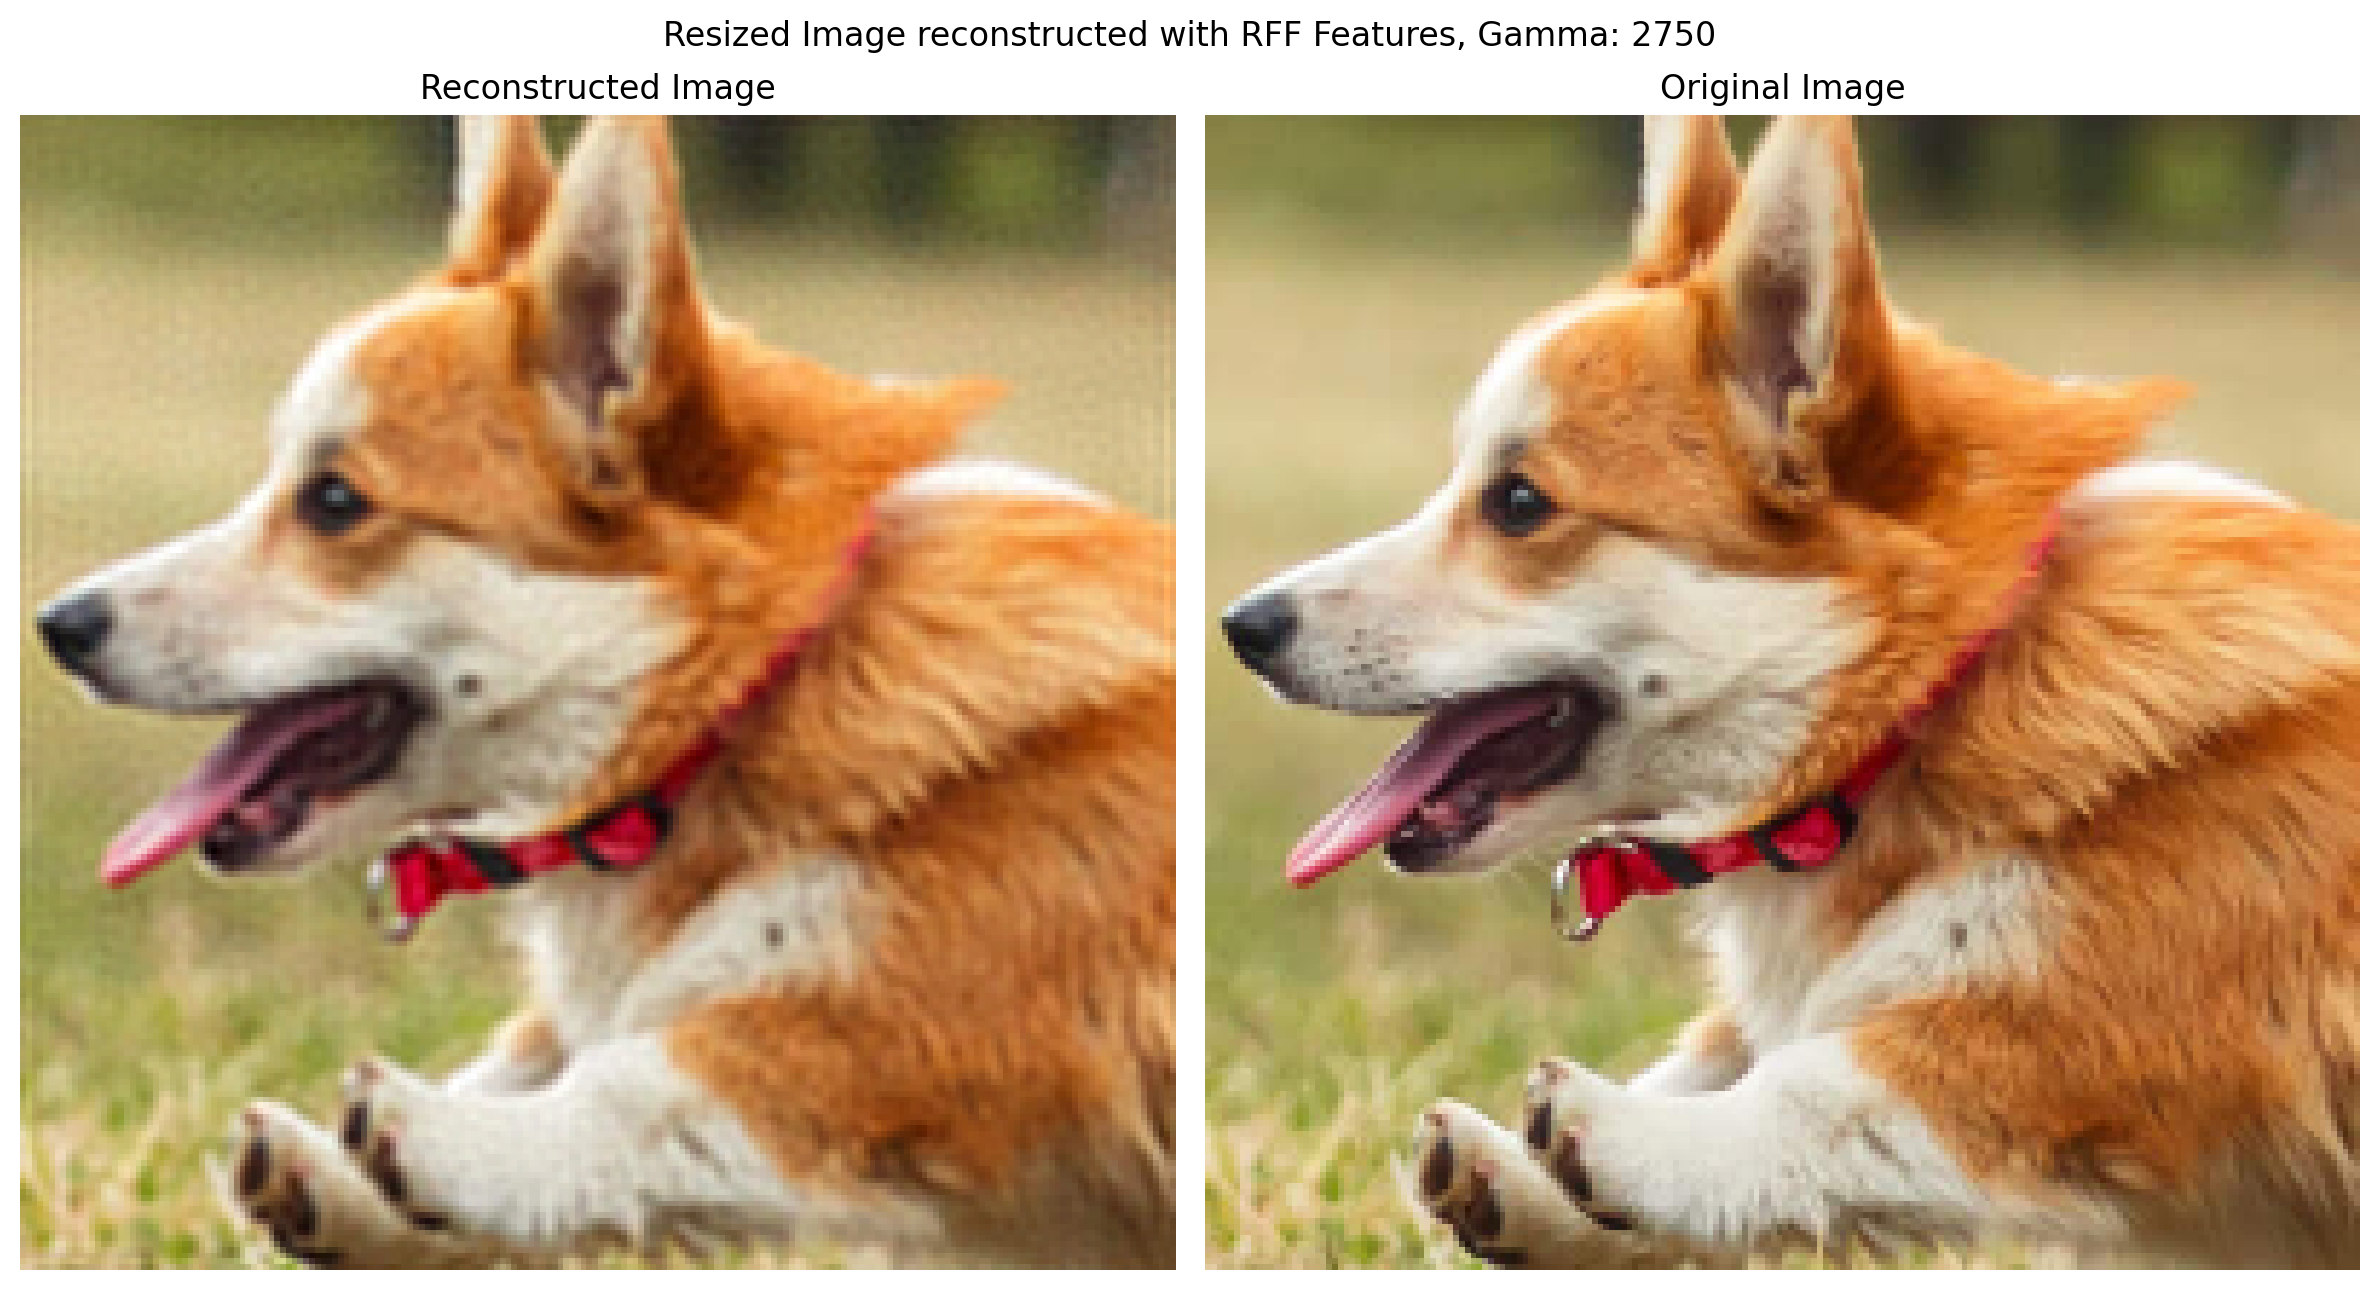

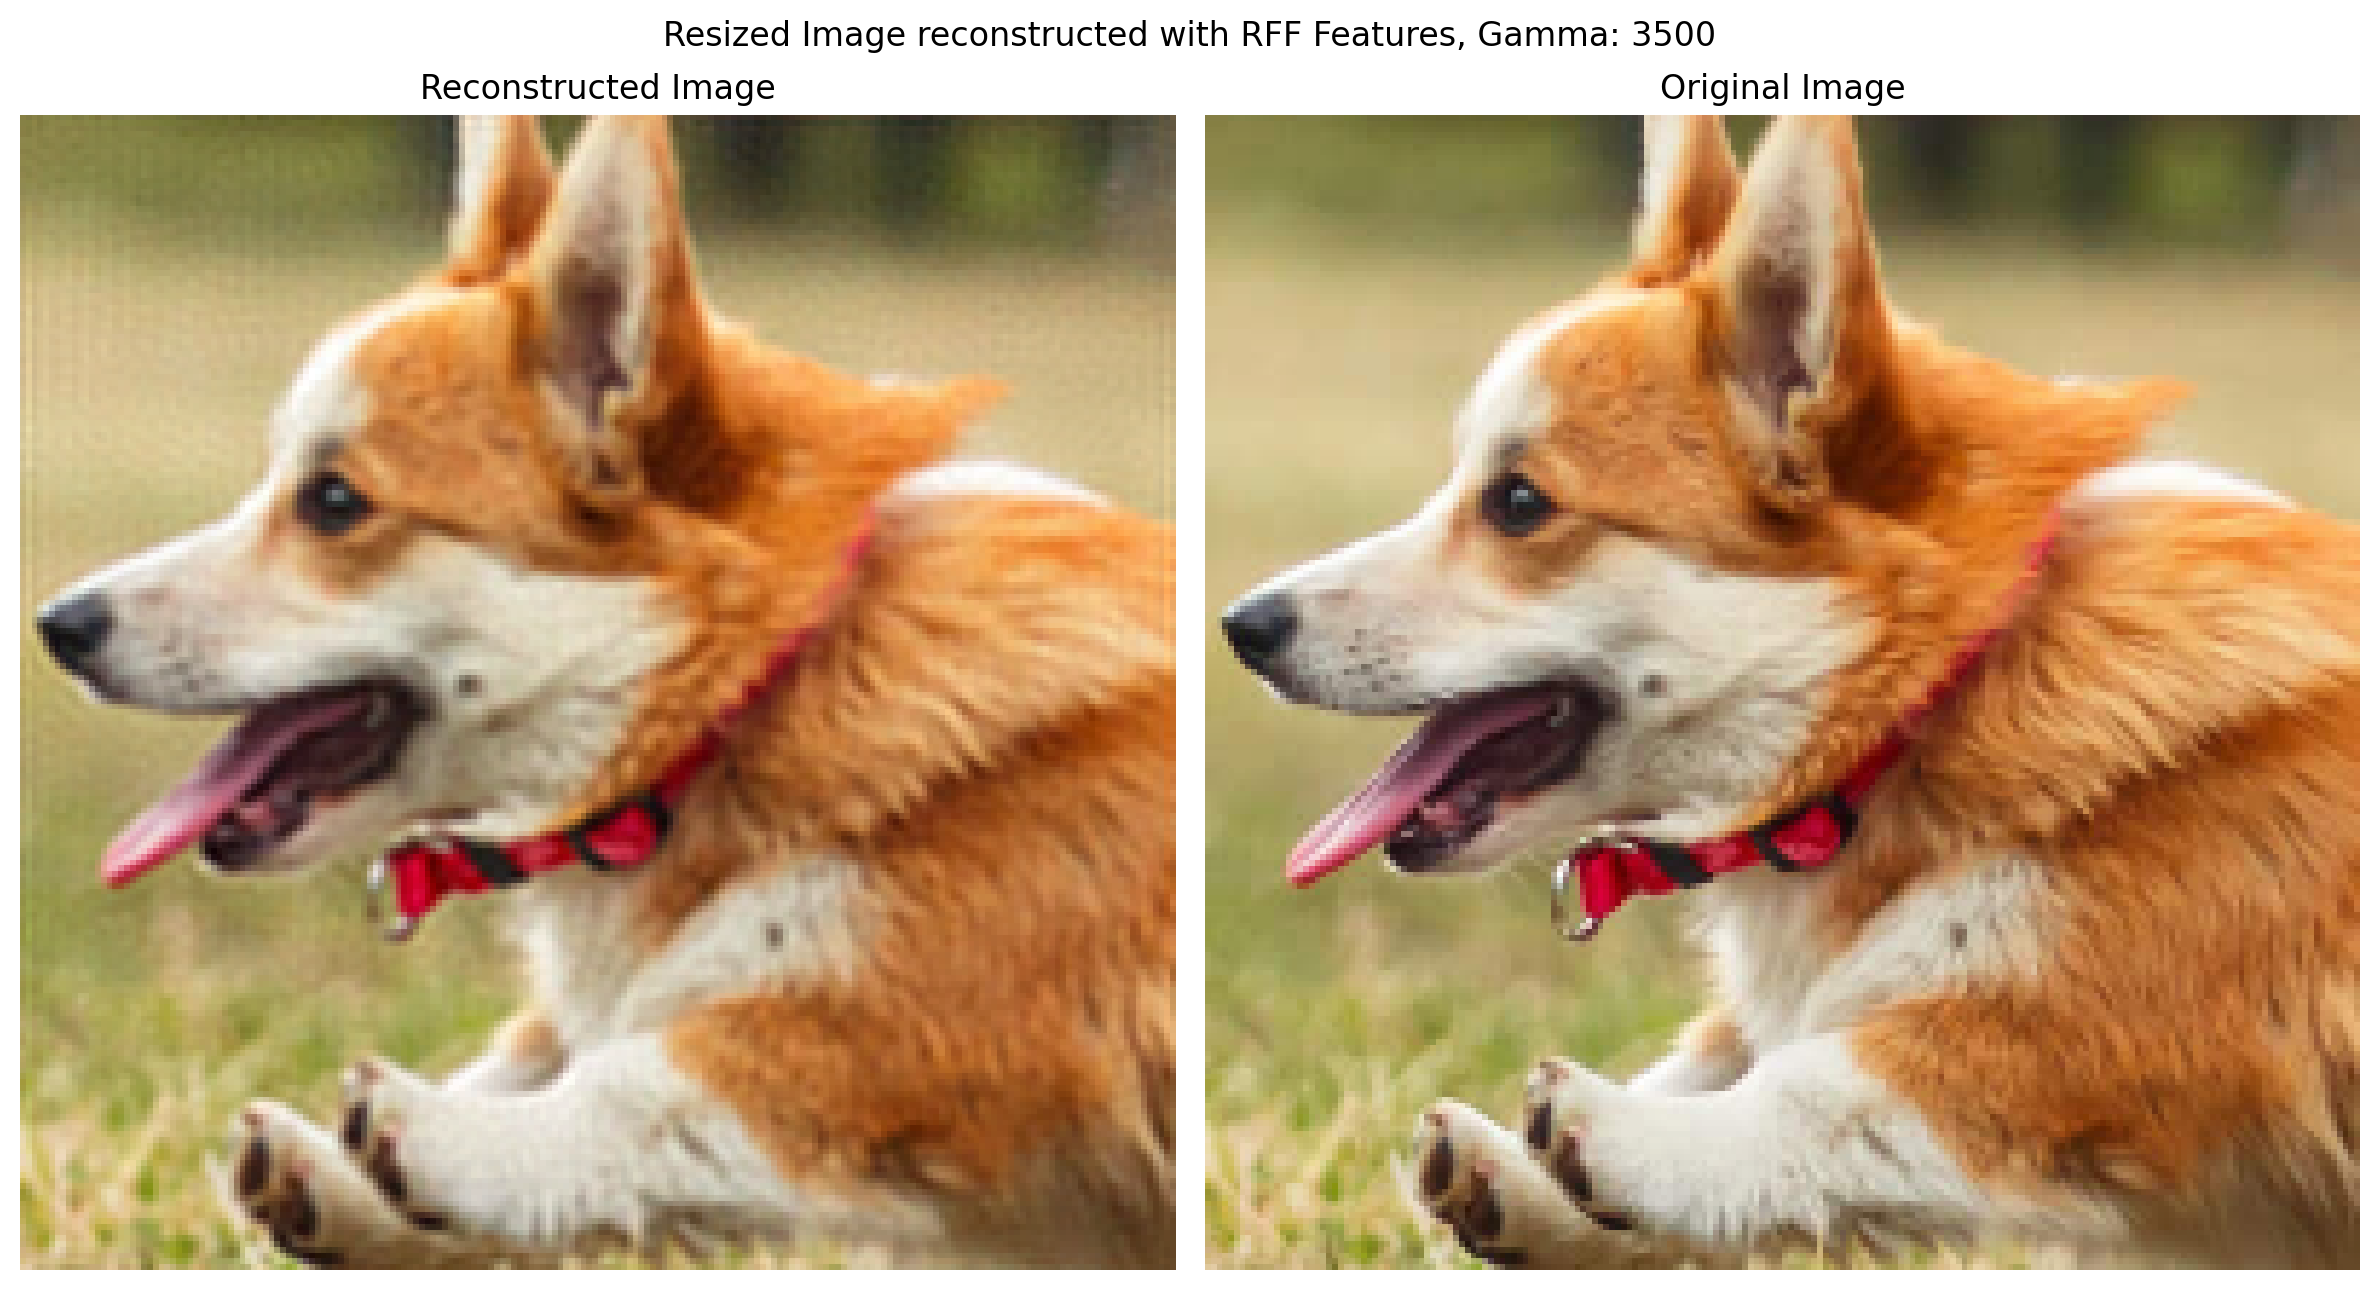

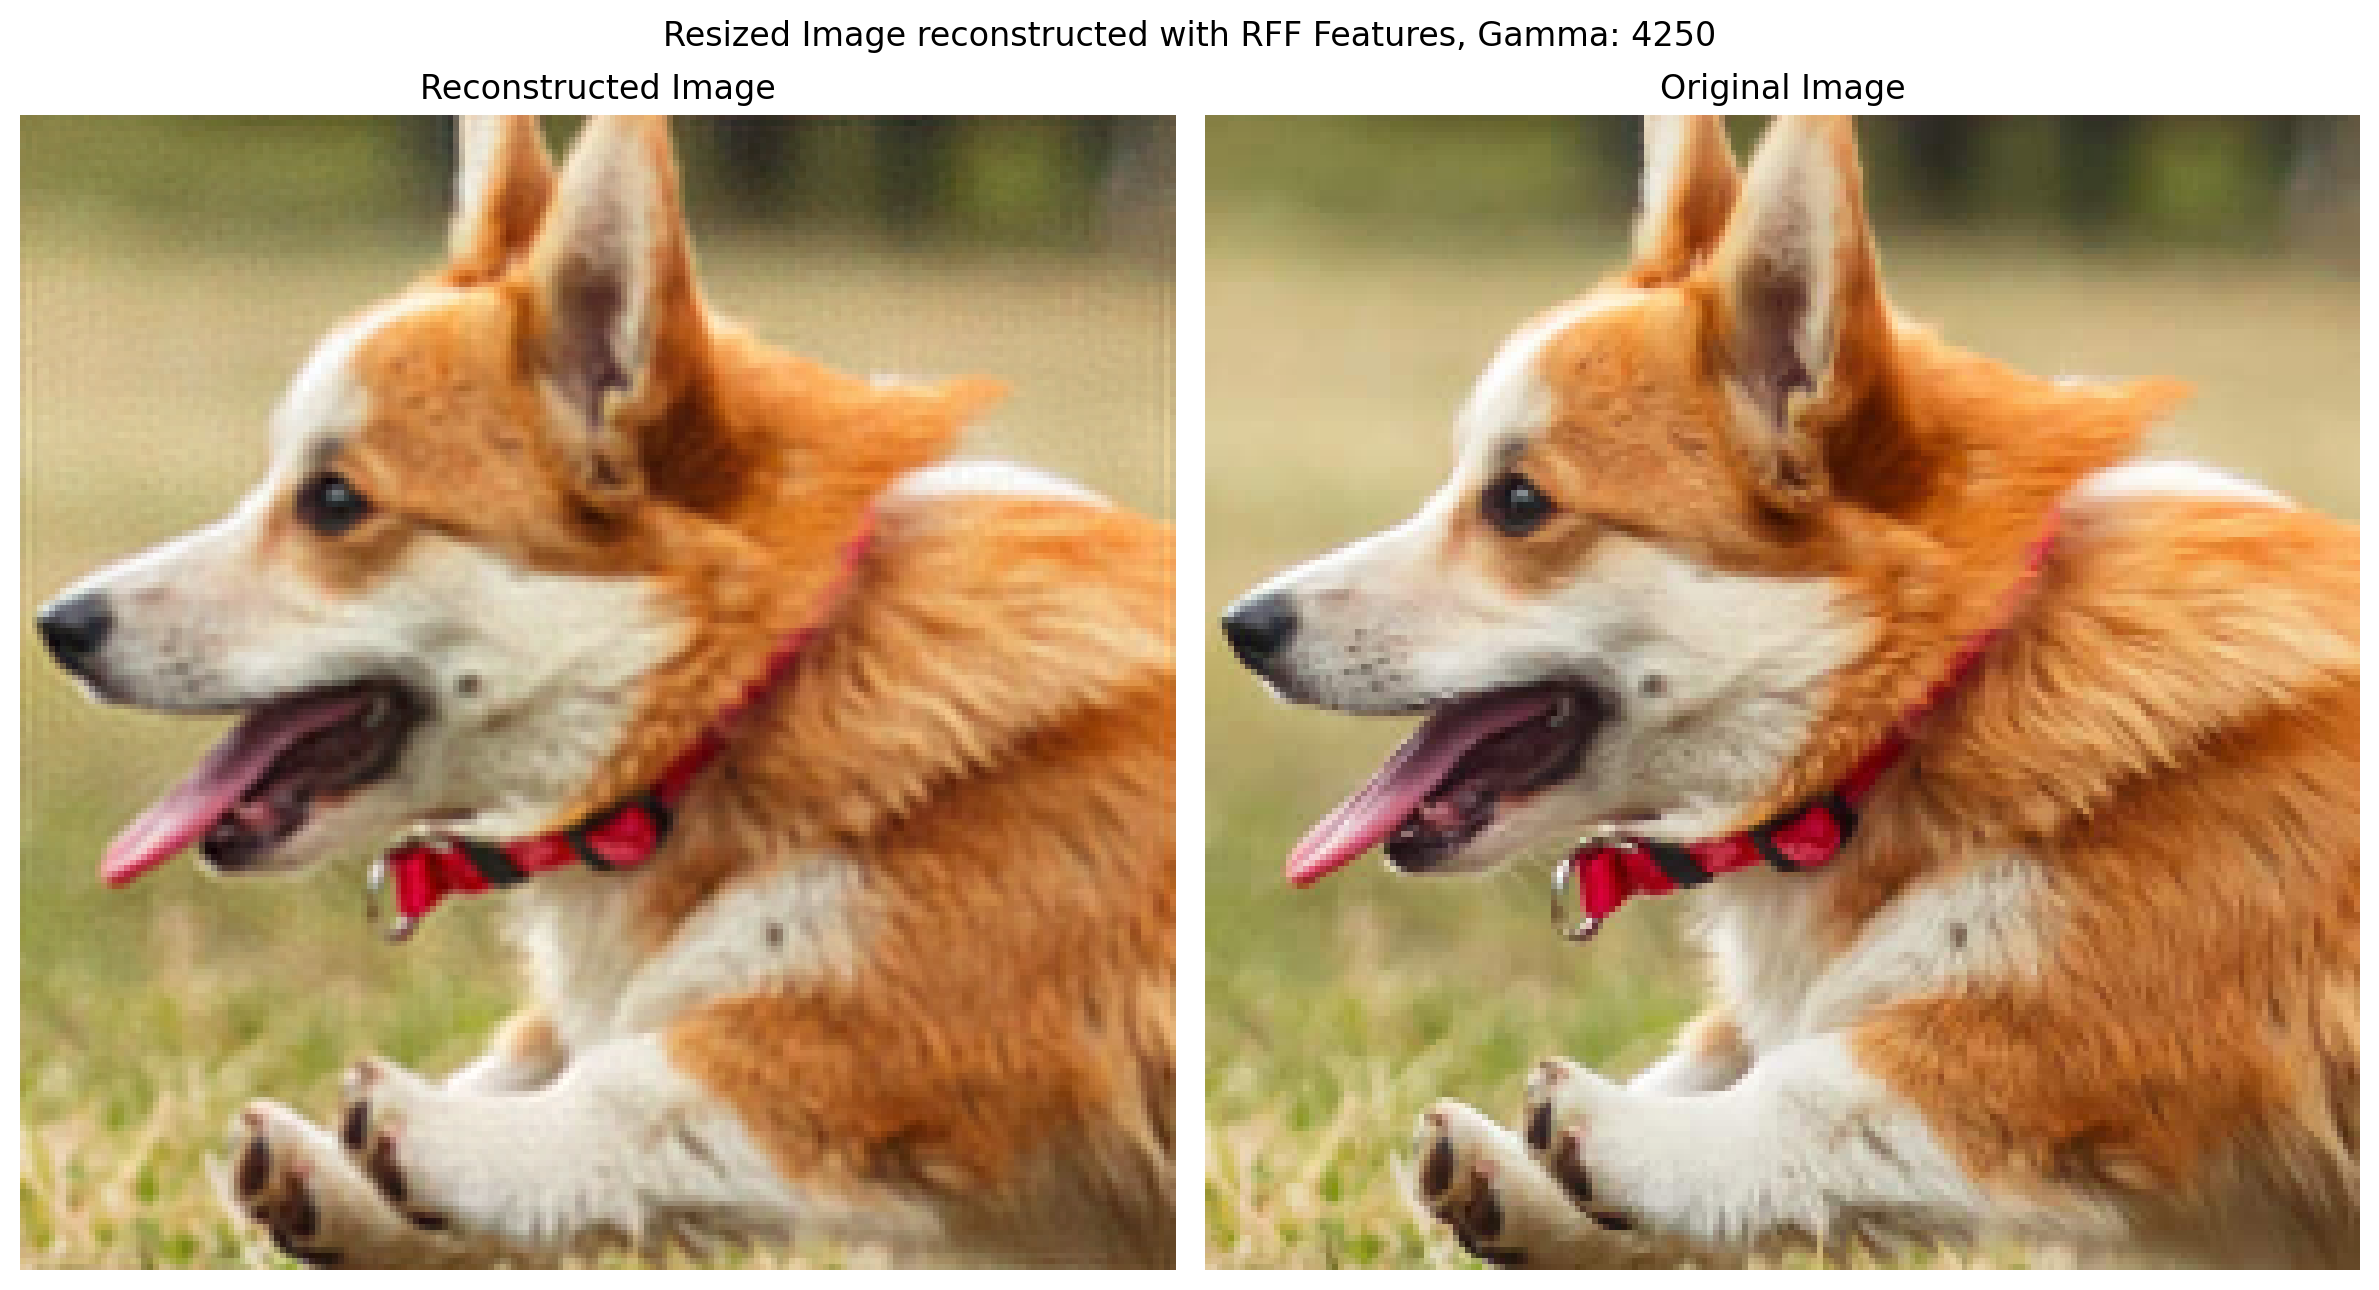

In [18]:
for gamma in [2750, 3500, 4250]:
  X_rff = create_rff_features(dog_X_scaled, 30000, gamma, random_state = 42) # num_of_features = 37500, gamma = 0.008
  net = LinearModel(X_rff.shape[1], 3)
  net.to(device)
  train(net, 0.001, X_rff, dog_Y, 2500)
  torch.cuda.empty_cache()
  plot_reconstructed_and_original_image(resized_image, net, X_rff, f'Resized Image reconstructed with RFF Features, Gamma: {gamma}', scale=1)